In [ ]:
# CVAE: concat x and y as input and output

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelBinarizer

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

train_dataset = datasets.MNIST(root='./num/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='./num/',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [8]:
print(train_loader.dataset.train_labels)

tensor([5, 0, 4,  ..., 5, 6, 8])


epoch: 0, loss: 1949.834961, recon_loss: 1842.812378, KLD: 107.022545


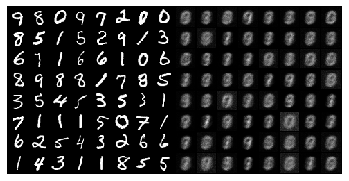

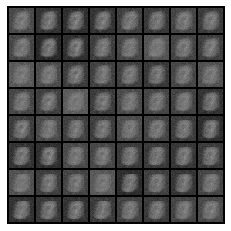

epoch: 1, loss: 1583.225952, recon_loss: 1418.010986, KLD: 165.214996


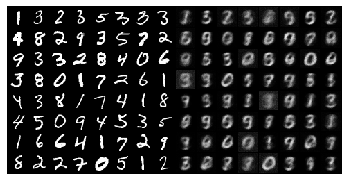

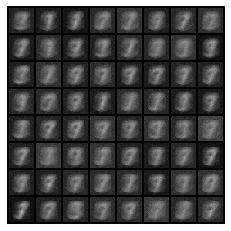

epoch: 2, loss: 1356.527588, recon_loss: 1160.611328, KLD: 195.916290


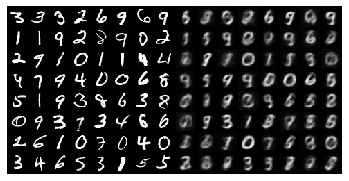

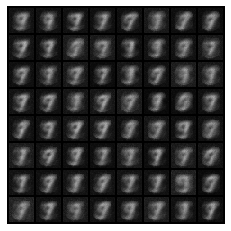

epoch: 3, loss: 1247.046875, recon_loss: 1049.758301, KLD: 197.288528


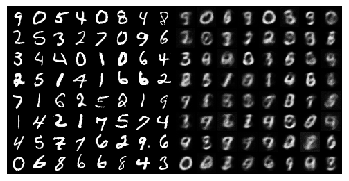

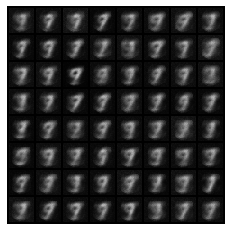

epoch: 4, loss: 1254.224731, recon_loss: 1069.945190, KLD: 184.279526


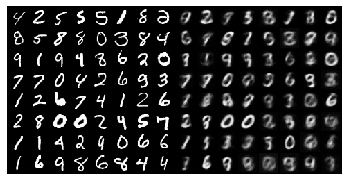

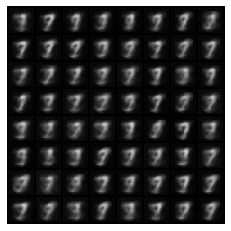

epoch: 5, loss: 1164.121094, recon_loss: 964.550903, KLD: 199.570251


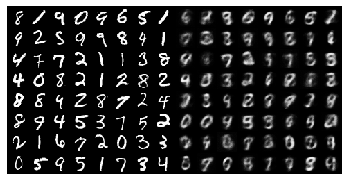

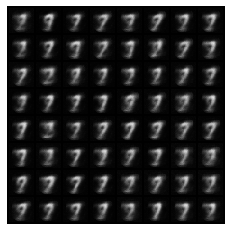

epoch: 6, loss: 1223.243530, recon_loss: 1012.338745, KLD: 210.904816


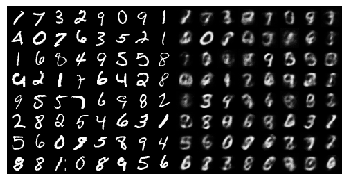

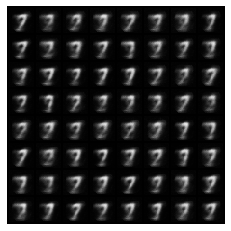

epoch: 7, loss: 1102.825195, recon_loss: 911.284729, KLD: 191.540497


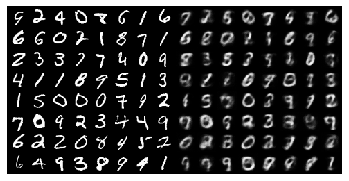

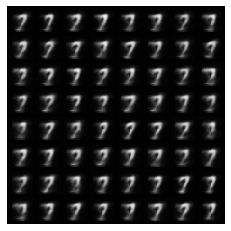

epoch: 8, loss: 1000.894653, recon_loss: 779.797729, KLD: 221.096924


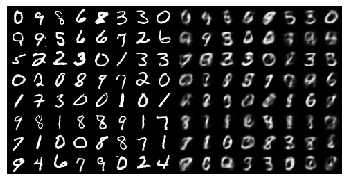

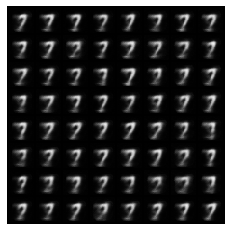

epoch: 9, loss: 1110.334717, recon_loss: 872.512878, KLD: 237.821838


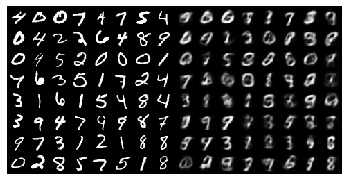

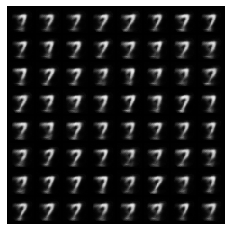

epoch: 10, loss: 1091.232910, recon_loss: 885.868713, KLD: 205.364227


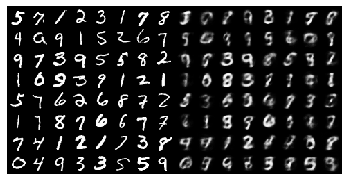

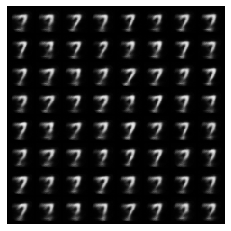

epoch: 11, loss: 1121.049194, recon_loss: 887.647095, KLD: 233.402084


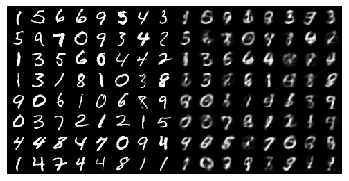

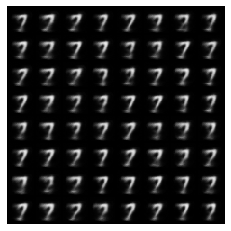

epoch: 12, loss: 993.811646, recon_loss: 754.327026, KLD: 239.484604


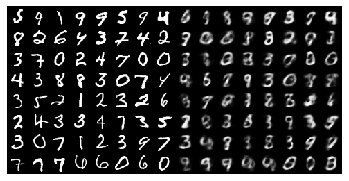

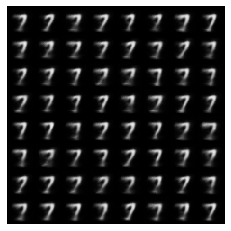

epoch: 13, loss: 945.796631, recon_loss: 709.240723, KLD: 236.555908


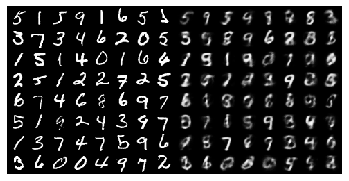

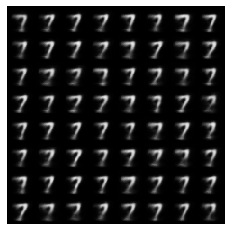

epoch: 14, loss: 1038.703003, recon_loss: 805.924805, KLD: 232.778183


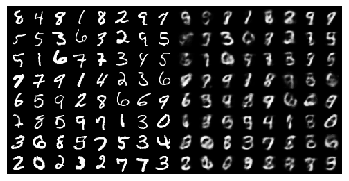

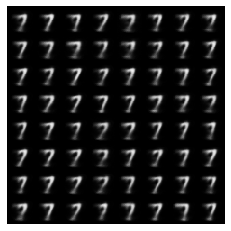

epoch: 15, loss: 1043.302246, recon_loss: 810.817139, KLD: 232.485046


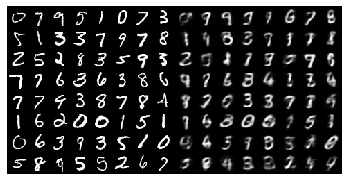

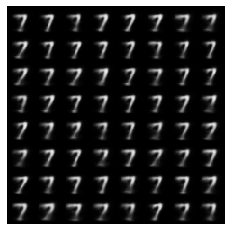

epoch: 16, loss: 926.390381, recon_loss: 702.382080, KLD: 224.008301


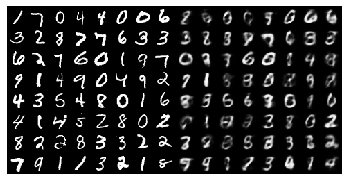

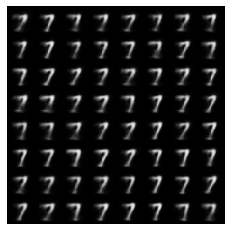

epoch: 17, loss: 995.877258, recon_loss: 754.416626, KLD: 241.460648


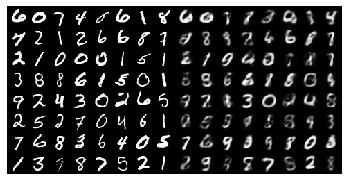

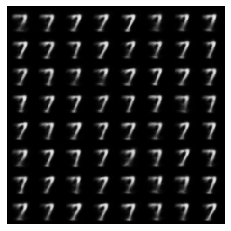

epoch: 18, loss: 984.601685, recon_loss: 726.484924, KLD: 258.116760


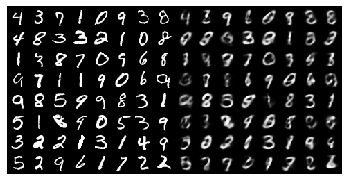

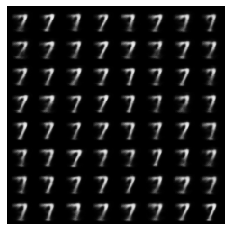

epoch: 19, loss: 1017.575195, recon_loss: 766.594849, KLD: 250.980331


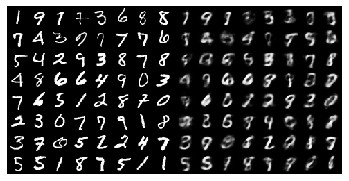

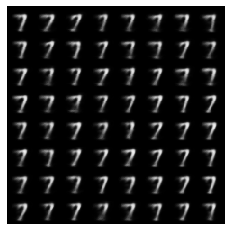

epoch: 20, loss: 966.757446, recon_loss: 741.487671, KLD: 225.269791


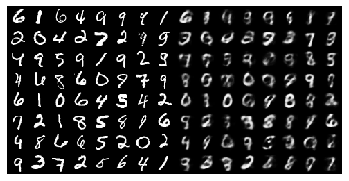

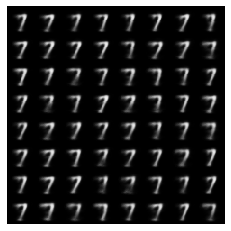

epoch: 21, loss: 1052.785034, recon_loss: 791.348816, KLD: 261.436218


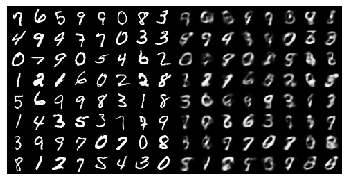

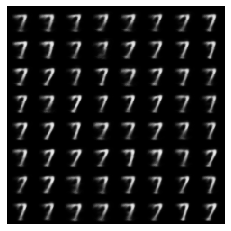

epoch: 22, loss: 928.034790, recon_loss: 682.553345, KLD: 245.481445


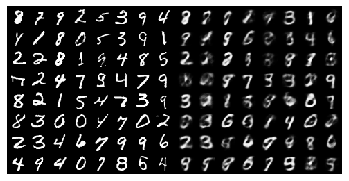

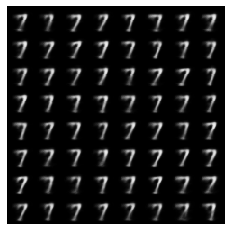

epoch: 23, loss: 908.841248, recon_loss: 674.545227, KLD: 234.296005


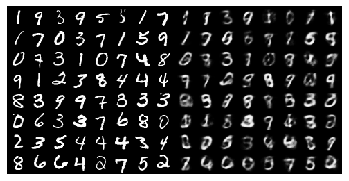

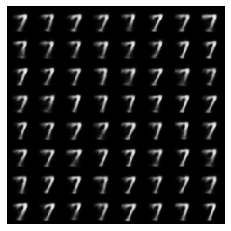

epoch: 24, loss: 924.868835, recon_loss: 688.806885, KLD: 236.061935


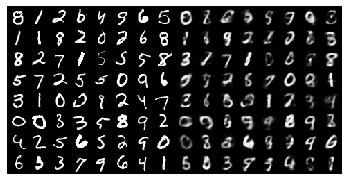

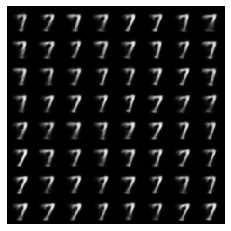

epoch: 25, loss: 868.841675, recon_loss: 618.030273, KLD: 250.811432


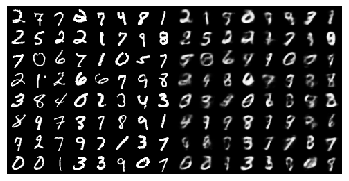

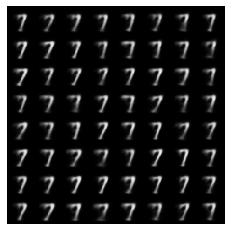

epoch: 26, loss: 968.423950, recon_loss: 708.780090, KLD: 259.643890


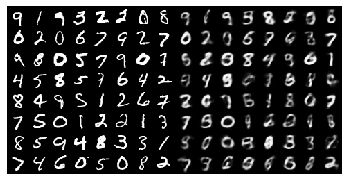

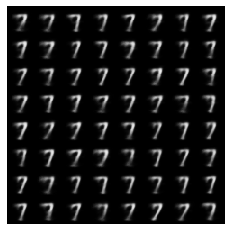

epoch: 27, loss: 865.174316, recon_loss: 626.357666, KLD: 238.816620


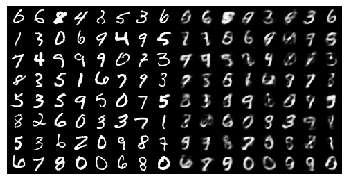

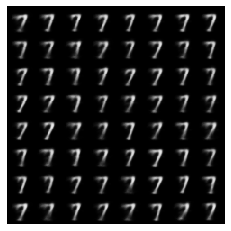

epoch: 28, loss: 827.928040, recon_loss: 601.827393, KLD: 226.100662


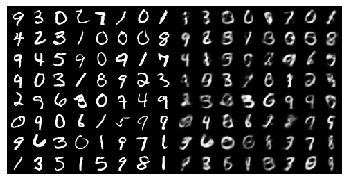

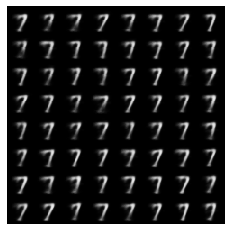

epoch: 29, loss: 882.274658, recon_loss: 640.244873, KLD: 242.029755


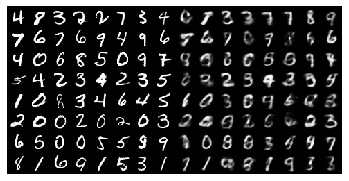

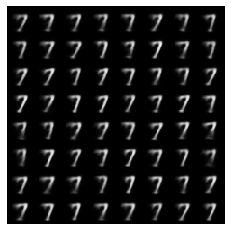

In [16]:
class CVAE(nn.Module):
    def __init__(self, x_dim1, x_dim2, y_dim, h_dim, z_dim):
        super(CVAE, self).__init__()
        
        self.x_dim1 = x_dim1
        self.x_dim2 = x_dim2
        self.y_dim = y_dim
        self.z_dim = z_dim
        
        self.lb = LabelBinarizer()
        
        # encoder
        # todo: conv pool relu bn
        self.fc1 = nn.Linear(x_dim1 * x_dim2 + y_dim, h_dim) # concat x and y
        self.fc2 = nn.Linear(h_dim, z_dim) # for mu
        self.fc3 = nn.Linear(h_dim, z_dim) # for logs2
        
        # decoder
        self.fc4 = nn.Linear(z_dim + y_dim, h_dim)           # concat z and y
        self.fc5 = nn.Linear(h_dim, x_dim1 * x_dim2 + y_dim) # concat x and y
        
    def one_hot(self, y: torch.FloatTensor):
        y_n = y.cpu().numpy()
        self.lb.fit(list(range(0, 10)))
        y_one_hot = self.lb.transform(y_n)
        floatTensor = torch.FloatTensor(y_one_hot)
        return floatTensor.to(device)
    
    def encode(self, x, y):
        """
        :param: x: input vector, size: (B, C, H, W)
        :param: y: input label, size: (B, S)
        :return: mu, logs2: parameters of Gaussian distribution of latent variable z
        """
        x = x.view(-1, self.x_dim1 * self.x_dim2)
        y = self.one_hot(y)
        con = torch.cat((x, y), dim=1)
        
        h = F.relu(self.fc1(con))
        mu = self.fc2(h)
        logs2 = self.fc3(h) 
        return mu, logs2
    
    def sample_from_gauss(self, mu, logs2):
        """
        :param: mu, logs2: mean and log(std^2) of Gaussian distrubution
        :return: z: the sampled result
        """
        std = torch.exp(logs2 * 0.5)
        eps = torch.randn_like(std)
        return mu + std * eps
        
    
    def decode(self, z, y):
        """
        :param: z: latent variable z
        :param: y: input label
        :return: xy: concatenation of x and y, size: (B, C * H * W + S)
        :return: x: the reconstructed image vector, size: (B, C, H, W)
        :return: y: the reconstructed label, size: (B, S)
        """
        y = self.one_hot(y)
        con = torch.cat((z, y), dim=1)
        
        h = F.relu(self.fc4(con))
        xy = torch.sigmoid(self.fc5(h)) 
        
        x = xy[:, :self.x_dim1 * self.x_dim2]
        x = x.view(-1, 1, self.x_dim1, self.x_dim2)
        
        y = xy[:, -self.y_dim:]
        
        return xy, x, y
    
    def forward(self, x, y):
        mu, logs2 = self.encode(x, y)
        z = self.sample_from_gauss(mu, logs2)
        xy, x, y = self.decode(z, y)
        return xy, x, y, mu, logs2

    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
LR = 1e-4

cvae = CVAE(x_dim1=28, x_dim2=28, y_dim=10, h_dim=256, z_dim=64).to(device)
optimizer = optim.Adam(
    cvae.parameters(),
    lr=LR,
)

epoch = 30


def loss_func(recon_x, images, labels, mu, logs2):
    labels = cvae.one_hot(labels)
    images = images.view(-1, 784)
    inputs = torch.cat((images, labels), dim=1)
    
    reconstruction_loss = F.mse_loss(inputs, recon_x, reduction='sum') # keypoint

    divergence = 0.5 * torch.sum(torch.exp(logs2) + torch.pow(mu, 2) - 1. - logs2)

    loss = reconstruction_loss + divergence

    return loss, reconstruction_loss, divergence


loss_log = []

for epo in range(epoch):
    for i, data in enumerate(train_loader):
        images = data[0].to(device)
        labels = data[1].to(device)

        res, _, _, mu, logs2 = cvae(images, labels)

        loss, recon_loss, KLD = loss_func(res, images, labels, mu, logs2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    print("epoch: {}, loss: {:3f}, recon_loss: {:3f}, KLD: {:3f}".format(epo, loss.item(), recon_loss.item(), KLD.item()))
    loss_log.append((loss.item(), recon_loss.item(), KLD.item()))
    
    # reconstruct images from test data
    xs = iter(test_loader).next()[0].to(device)
    ys = iter(test_loader).next()[1].to(device)
    origin_grid = torchvision.utils.make_grid(xs).cpu().numpy().transpose(1, 2, 0)
    
    _, recons_x, recons_y, _, _ = cvae(xs, ys)
    reconstructed_grid = torchvision.utils.make_grid(recons_x).cpu().detach().numpy().transpose(1, 2, 0)
    
    # generate images from noise
    zs = torch.rand(64, 64).to(device)
    ys = [i * torch.ones(64).to(device) for i in range(10)] 
    gen_xy_x_y = [cvae.decode(zs, y) for y in ys]
    gen_x = [g[1] for g in gen_xy_x_y]
    generated_grids = [torchvision.utils.make_grid(gx).cpu().detach().numpy().transpose(1, 2, 0) for gx in gen_x]
    
    img = np.hstack([origin_grid, reconstructed_grid])
    plt.imshow(img)
    plt.axis('off')
    plt.imsave('result/cvae/ori_rec_{}.png'.format(epo), img)
    plt.show()

    plt.imshow(generated_grids[7])
    plt.axis('off')
    plt.show()
    for i, gg in enumerate(generated_grids):
        plt.imsave('result/cvae/gen_epo{}_{}.png'.format(epo, i), gg)

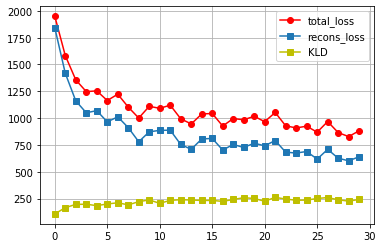

In [17]:
total_loss_log = [l[0] for l in loss_log]
recons_loss_log = [l[1] for l in loss_log]
KLD_log = [l[2] for l in loss_log]

plt.grid()
plt.plot(range(len(total_loss_log)), total_loss_log, 'ro-')
plt.plot(range(len(recons_loss_log)), recons_loss_log, 's-')
plt.plot(range(len(KLD_log)), KLD_log, 'ys-')
plt.legend(('total_loss', 'recons_loss', 'KLD'))

plt.savefig('result/cvae/train_log.png')